# Coffe Strength Control System

So, my idea to make a not too complicated fuzzy control system was to make a coffe machine that changes the strength of the coffee depending on several factors expressed through fuzzy logic.

A lot of people drink coffee for taste and for the energy boost. However, depending on what `time_of_day` we have, what our current `energy_level`, our `need_for_energy` and our typical `taste_preference` are, we might want to adapt the strength of the `coffe_strength`. E.g when it is late, it is typically a bad idea to drink coffee. So, if we drink coffee better be less strong. Thus, our sleep quality will suffer less.

## Import necessary libs

In [1]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

## We define our Fuzzy Sets and Variables

### Fuzzy Sets

In [2]:
# Antecedents (Inputs)
time_of_day = ctrl.Antecedent(np.arange(0, 25, 1), 'time_of_day')        # 0–24 hours
energy_level = ctrl.Antecedent(np.arange(0, 11, 1), 'energy_level')      # 0–10
need_for_energy = ctrl.Antecedent(np.arange(0, 11, 1), 'need_for_energy')# 0–10
taste_preference = ctrl.Antecedent(np.arange(0, 11, 1), 'taste_preference') # 0–10

# Consequent (Output)
coffee_strength = ctrl.Consequent(np.arange(0, 11, 1), 'coffee_strength') # 0–10

### Fuzzy Variables and Membership functions


`time_of_day`:

For the `time_of_day` we consider only the most important times. Typically, we say that we shouldn't drink coffe after around 2pm. So, before anything before can be strong, while after likely should weaken coffee strength. Thus, we use four fuzzy variables: early_morning, late_morning, afternoon and evening. Since, big distinctions after noon aren't really necessary.

`energy_level`:
The energy level is really simply. We either lack energy, have high energy or are somewhere in between.

`need_for_energy`:
Here, we determine whether we really need energy -> energize or rather need to relax -> relax or smth in between -> normal.

`taste_preference`:
Maybe our preference is really strong coffee, thus, it we still want strong coffee, even though we may not need strong coffee.

`coffee_strenght`:
Since I don't really know what exactly makes the coffee strong, I guess there are several factors, we simply say weak, medium or strong coffee.

/home/silas/uni/fuzzy-tutorial/.venv/lib/python3.11/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


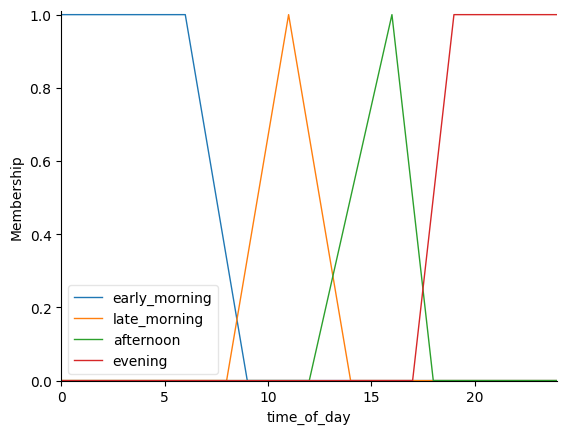

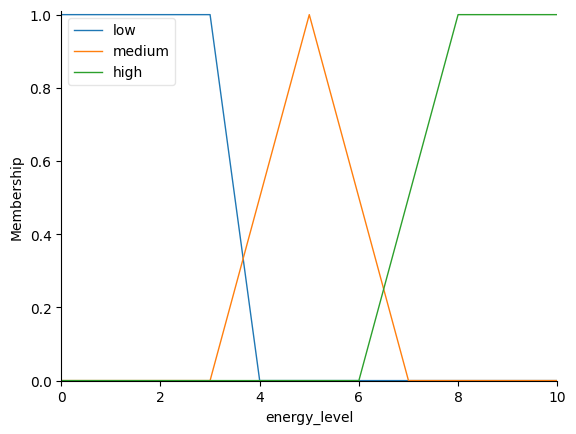

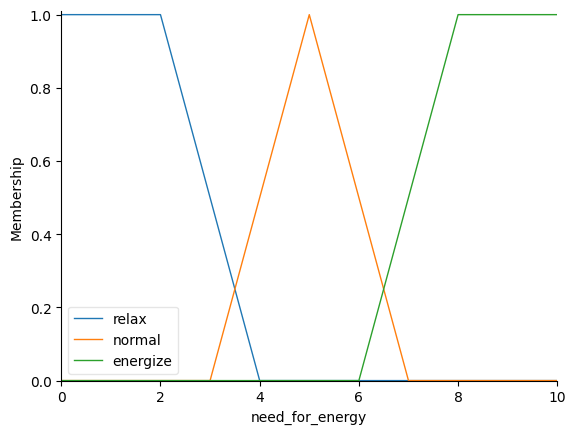

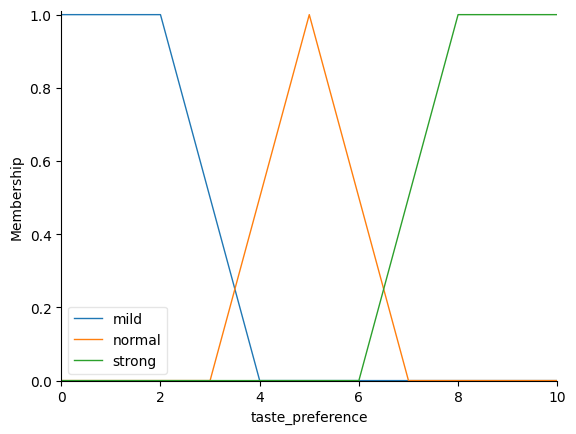

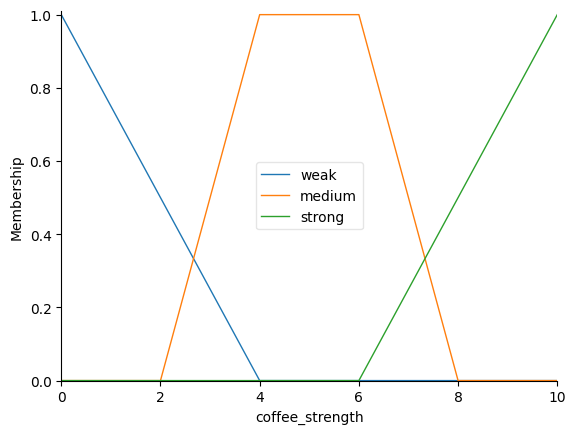

In [3]:
# Time of Day (hours)
## The earlier mornings are when drinking coffee makes most sense => if we drink coffee it can be strong
time_of_day['early_morning'] = fuzz.trapmf(time_of_day.universe, [0,0, 6, 9])
time_of_day['late_morning']  = fuzz.trimf(time_of_day.universe, [8, 11, 14])
## Everythin after noon it where the stronger the coffee the more negative the effect on our sleep.
time_of_day['afternoon']     = fuzz.trimf(time_of_day.universe, [12, 16, 18])
time_of_day['evening']       = fuzz.trapmf(time_of_day.universe, [17, 19, 24, 24])

# Energy Level
energy_level['low']    = fuzz.trapmf(energy_level.universe, [0, 0, 3, 4])
energy_level['medium'] = fuzz.trimf(energy_level.universe, [3, 5, 7])
energy_level['high']   = fuzz.trapmf(energy_level.universe, [6, 8, 10, 10])

# Need for Energy
need_for_energy['relax']    = fuzz.trapmf(need_for_energy.universe, [0, 0, 2, 4])
need_for_energy['normal']   = fuzz.trimf(need_for_energy.universe, [3, 5, 7])
need_for_energy['energize'] = fuzz.trapmf(need_for_energy.universe, [6, 8, 10, 10])

# Taste Preference
taste_preference['mild']   = fuzz.trapmf(taste_preference.universe, [0, 0, 2, 4])
taste_preference['normal'] = fuzz.trimf(taste_preference.universe, [3, 5, 7])
taste_preference['strong'] = fuzz.trapmf(taste_preference.universe, [6, 8, 10, 10])

# Coffee Strength (Output)
coffee_strength['weak']   = fuzz.trimf(coffee_strength.universe, [0, 0, 4])
coffee_strength['medium'] = fuzz.trapmf(coffee_strength.universe, [2, 4, 6, 8])
coffee_strength['strong'] = fuzz.trimf(coffee_strength.universe, [6, 10, 10])



# Optional: visualize membership functions
time_of_day.view()
energy_level.view()
need_for_energy.view()
taste_preference.view()
coffee_strength.view()

## Fuzzy Rules

Strong coffee rules:

- If time is not afternoon or evening and (need_for_energy is high or taste_preference is strong or energy_level is low) -> strong coffee
- This basically means in the morning we can go strong if any of the "strong factors" are present

Medium coffee rules:

- If time is not afternoon or evening and none of the strong factors are present -> medium coffee
- Afternoon is mostly medium coffee anyway -> medium coffee
- This makes sure that if morning but nothing really pushes strong, we just go medium

Evening rules:

- Evening usually means weak coffee so sleep is not disturbed -> weak coffee
- Except if need_for_energy is high and taste_preference is strong -> medium coffee
- This caps coffee late in the day unless you really want/need it


In [4]:
# Strong coffee:
# If it's not afternoon/evening and (need for energy high or taste strong or energy low) -> strong
rule_strong = ctrl.Rule(
    (~time_of_day['afternoon'] & ~time_of_day['evening']) & 
    (need_for_energy['energize'] | taste_preference['strong'] | energy_level['low']),
    coffee_strength['strong']
)

# Medium coffee:
# If it's not afternoon/evening and none of the "strong factors" are present -> medium
rule_medium = ctrl.Rule(
    (~time_of_day['afternoon'] & ~time_of_day['evening']) &
    (~need_for_energy['energize'] & ~taste_preference['strong'] & ~energy_level['low']),
    coffee_strength['medium']
)

# Afternoon:
# Default medium coffee if nothing else triggers
rule_afternoon = ctrl.Rule(time_of_day['afternoon'], coffee_strength['medium'])

# Evening:
# Usually weak, unless need for energy and taste are both high -> medium
rule_evening_weak = ctrl.Rule(
    time_of_day['evening'] & (~(need_for_energy['energize'] & taste_preference['strong'])),
    coffee_strength['weak']
)
rule_evening_medium = ctrl.Rule(
    time_of_day['evening'] & (need_for_energy['energize'] & taste_preference['strong']),
    coffee_strength['medium']
)


## Control System creation

In [5]:
# Create the control system with the new rules
coffee_ctrl = ctrl.ControlSystem([
    rule_strong,
    rule_medium,
    rule_afternoon,
    rule_evening_weak,
    rule_evening_medium
])

coffee_sim = ctrl.ControlSystemSimulation(coffee_ctrl)

## Example with values

Recommended coffee strength: 3.76


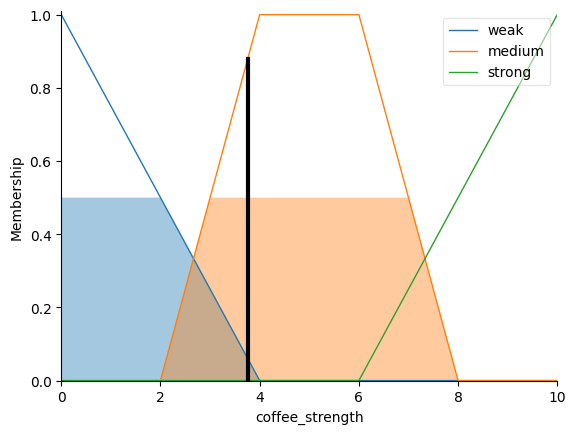

In [6]:
# Pass inputs to the ControlSystem using Antecedent labels
coffee_sim.input['time_of_day'] = 18 # 18:00
coffee_sim.input['energy_level'] = 10 # Super energy loaded
coffee_sim.input['need_for_energy'] = 2 # We don't need the energy
coffee_sim.input['taste_preference'] = 5 # We like it medium

# Crunch the numbers
coffee_sim.compute()

# Display the crisp output
print(f"Recommended coffee strength: {coffee_sim.output['coffee_strength']:.2f}")

# Visualize the result on the membership function
coffee_strength.view(sim=coffee_sim)
